In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pyabf
import os
%matplotlib inline

# What do we want to do? 
We’ll need to create an operational definition of the "bout:  

1.) We’ll need to set a minimum threshold over baseline in which the bout begins. 

- Let’s start with 0.001V.  
- Note: This may need to be actively adjusted per animal given variance in noise each day. 

2.) Once the threshold goes back to baseline (under threshold) we’ll have to set a minimum duration for how long it must stay under threshold for the bout to end.  

- Let’s start with 0.5 seconds.  

 

For analysis of each bout, we’ll want metrics generated for: 

1) Duration of bout 

2) Peak velocity 

3) AVG velocity 

4) Peak acceleration 

5) AVG acceleration 


# What does our data look like? 
 ‘Channel_05’ is the raw velocity and ‘Channel_05_ts_step’ is the sampling frequency (1000 Hz, i.e. 1 ms, which should be the same for all files). 'Channel_05' should be a continuous trace. 

Our modifiable parameters are below. These are `voltage_cutoff`, which is the minimum voltage we want to flag as movement, the `minimum_duration`, which is the minimum duration a bout has to under the cutoff in order to end a bout and `ts_step`, which is the time step in seconds (usually .0001, but different for the non-training data). 

In [361]:
voltage_cutoff = .02
minumum_duration = 1
ts_step = 0.001 # Time step in seconds 
sampling_rate_hz = int(1/ts_step)
sampling_rate_hz

1000

# Import Data 
First, we're going to use the pyabf library to read the abf file directly. Let's explore the output file a bit. 

In [362]:

abf = pyabf.ABF('C://Users//ameet/Box Sync/BevanLab/Projects/treadmill_analysis//ABF FILES//2013_06_03_0008.abf')
abf.setSweep(sweepNumber = 0, channel = 1)
print(abf.sweepY) # displays sweep data (ADC)
print(abf.sweepX) # displays sweep times (seconds)
print(abf.sweepC) # displays command waveform (DAC)
sweepY = -(np.array(abf.sweepY))
sweepX = np.array(abf.sweepX)

[0.0012 0.0012 0.0018 ... 0.0018 0.0009 0.0015]
[ 0.     0.001  0.002 ... 64.509 64.51  64.511]
[0. 0. 0. ... 0. 0. 0.]


In [363]:
plt.plot(sweepX, sweepY)

Now, let's explore our data file a little. 

In [364]:
plt.plot(sweepX[sampling_rate_hz: 2 * sampling_rate_hz], sweepY[sampling_rate_hz: 2 * sampling_rate_hz], label = 'vel')
step = 100
acceleration = np.diff(average_downsampler(sweepY, step = step)) * sampling_rate_hz/step
plt.xlabel('Time (sec)')
plt.ylabel('$m/s$')
plt.title('Treadmill Velocity Trace')
plt.savefig('vel_test.png')
plt.show()


plt.plot(np.arange(sampling_rate_hz//step)/(sampling_rate_hz//step) + 1, acceleration[sampling_rate_hz//step: 2 * sampling_rate_hz//step], label = 'acc')
plt.xlabel('Time (sec)')
plt.ylabel('$m/s^2$')
plt.title('Treadmill Acceleration Trace')
plt.legend()
plt.savefig('acc_trace.png')
plt.show()

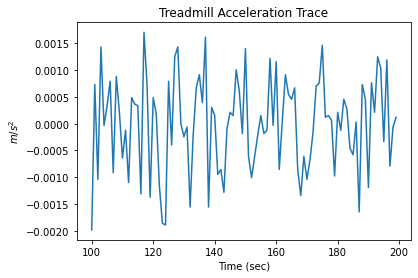

In [289]:
plt.plot(np.arange(sampling_rate_hz//10) + sampling_rate_hz//10, acceleration[sampling_rate_hz//10: 2 * sampling_rate_hz//10], label = 'acc')
plt.xlabel('Time (sec)')
plt.ylabel('$m/s^2$')
plt.title('Treadmill Acceleration Trace')
plt.savefig('acc_trace.png')
plt.show()

Text(0.5, 1.0, 'Treadmill Acceleration Trace')

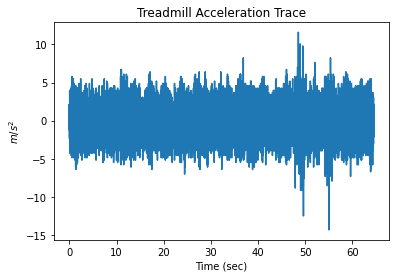

In [290]:
#plt.plot(sweepX, sweepY)
acceleration = np.diff(sweepY) * sampling_rate_hz
plt.plot(sweepX[: -1], acceleration)
plt.xlabel('Time (sec)')
plt.ylabel('$m/s^2$')
plt.title('Treadmill Acceleration Trace')


In the plot above, we plot Voltage against Seconds, where we see a single movement bout. Let's see what happens if we just start and end a bout whenever Voltage is above .1

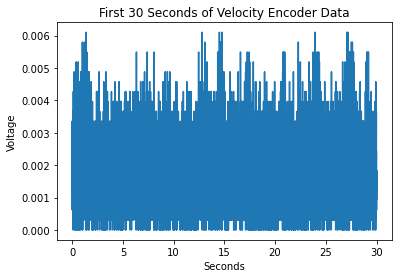

In [326]:

#above_cutoff = data['Channel_05'] > voltage_cutoff
above_cutoff = sweepY > voltage_cutoff
plt.vlines(np.arange(sampling_rate_hz * 30)[above_cutoff[:sampling_rate_hz * 30].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= 1.2, color = 'orange')
plt.plot(np.arange(sampling_rate_hz* 30)/sampling_rate_hz, np.abs(sweepY[:sampling_rate_hz * 30]))
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
#plt.savefig('example.png')
plt.show()

In [365]:
plot_trace(40, 60, sampling_rate_hz, above_cutoff, sweepY, save_name = '')

That actually works pretty well, but we have to account for those small gaps - how do we do that? We need to implement the minimum length of time our velocity encoder has to fall below the threshold. This is encoded by the `minimum_duration`. To get the number of timesteps that we need to look out for, we need to multiply `minimum_duration` by `sampling_rate_hz`. Then, for every `TRUE` value in `above_cutoff` (this is a boolean array with `TRUE` if it's above the cutoff and `FALSE` if it's below), we check if the next `minimum_duration` * `sampling_rate_hz` time steps are `FALSE`. If they are, we can stop the movement epoch. If they aren't, we continue until the next `TRUE`, where we start checking again. 

In [366]:
above_cutoff = sweepY > voltage_cutoff
plt.vlines(np.arange(sampling_rate_hz * 30)[above_cutoff[:sampling_rate_hz * 30].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= 1.2, color = 'orange')
plt.plot(np.arange(sampling_rate_hz* 30)/sampling_rate_hz, np.abs(sweepY[:sampling_rate_hz * 30]))
plt.title('First 30 Seconds of Velocity Encoder Data')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
#plt.savefig('example.png')
plt.show()

In [367]:
True_followed_by_false = above_cutoff[:-1] * (1 - above_cutoff[1:]) # this gives us an array of boolean values whenever there is a True followed by a False
indices = np.where(True_followed_by_false == 1)[0] + 1 # this converts the array of boolean values to a list of indices
for i, idx in enumerate(indices): 
    """
    We want to check if the next minumum_duration of seconds are
    all False
    """
    end_of_array = above_cutoff.shape[0] - 1
    curr_slice = above_cutoff[idx: min(idx + (minumum_duration * sampling_rate_hz), end_of_array)]
    if np.sum(curr_slice) > 10: # if there are more than 10 times it breaks the cutoff 
        if i + 1 != len(indices):
            end = min((minumum_duration * sampling_rate_hz + 1), (indices[i + 1] - idx))
        else: 
            end = min((minumum_duration * sampling_rate_hz + 1), len(above_cutoff) - idx - 1)
        above_cutoff[idx: idx + end] = np.array([True] * end)
        


In [368]:
def plot_trace(start, end, sampling_rate_hz, above_cutoff, sweepY, save_name = ''):
    #%matplotlib widget
    %matplotlib inline
    start_idx = sampling_rate_hz  * start
    end_idx = sampling_rate_hz * end
    xaxis = np.arange(sampling_rate_hz * (end - start))
    plt.vlines(start + xaxis[above_cutoff[start_idx:end_idx].reshape(-1)]/sampling_rate_hz, ymin = 0, ymax= 1.2, color = 'orange')
    plt.plot(start + xaxis/sampling_rate_hz, sweepY[start_idx:end_idx], label = 'Signal')
    plt.title('Velocity Encoder Data from {} to {} seconds'.format(start, end))
    plt.xlabel('Seconds')
    #plt.ion()
    plt.ylabel('Voltage')
    plt.legend()
    if save_name != '':
        plt.savefig(save_name)

    plt.show()

The function `plot_trace` takes in two arguments in seconds: start and end - these are currently set to 0 and 30 in the block below. The rest of the arguments won't need to be changed.

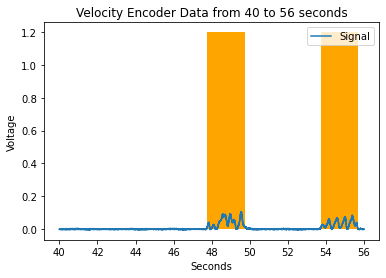

In [370]:
%matplotlib inline
plot_trace(40, 56, sampling_rate_hz, above_cutoff, sweepY, save_name = '')

In [ ]:
above_cutoff[0*sampling_rate_hz:30*sampling_rate_hz].shape

# Some preliminary before metrics

Before we start calulating metrics, let's make life a bit easier for us. We want to convert our boolean arrays to sets of indices. Effectively, currently, we have an array that is `True` for every time point that is in the epoch and `False` otherwise. Instead, we want sets of indices marking the start of every bout and the end of every bout. This would be structured: `[(start, end), (start, end)]`

In [371]:
from itertools import accumulate, groupby
indices = list(accumulate(sum(1 for _ in g) for _,g in groupby(above_cutoff)))
to_remove = []
for idx in range(len(indices) - 1):
    if idx % 2 == 1 and indices[idx + 1] - indices[idx] < 10:
        to_remove.append(idx)
        to_remove.append(idx + 1)
to_remove.append(len(indices) - 1)

counter = 0
for idx in to_remove:
    
    indices.pop(idx - counter)
    counter += 1
    



[47790, 49707, 53779, 55659]

Here's an interactive plot - this might error on other computers, let me know if you want to run this and it doesn't work

In [372]:

%matplotlib widget
indices_seconds = [i/sampling_rate_hz for i in indices]
plt.vlines(indices_seconds, color = 'orange', ymin = 0, ymax = 1.2)    
plt.plot(sweepX, sweepY)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Let's convert our continuous velocity trace to a continous acceleration trace. This should just be the first difference. IE. every element subtracted from every subsequent element (over time which is just one).

In [374]:
acceleration = np.diff(sweepY) * sampling_rate_hz
plt.plot(sweepX[:-1], acceleration)

In [398]:
def duration_of_all_bouts(indices):
    durations = []
    for i in range(len(indices) - 1):
        if i%2 == 0:
            start, end = indices[i], indices[i + 1]
            start = start/sampling_rate_hz
            end = end/sampling_rate_hz
            durations.append(end - start)
        
    return durations

In [399]:
def max_velocity_bouts(indices):
    max_vels = []
    for i in range(len(indices) - 1):
        if i%2 == 0:
            start, end = indices[i], indices[i + 1]
            max_vels.append(max(sweepY[int(start): int(end)]) * 100)

    return max_vels

In [402]:
def avg_velocity_bouts(indices):
    avg_vels = []
    for i in range(len(indices) - 1):
        if i%2 == 0:
            start, end = indices[i], indices[i + 1]
            avg_vels.append(np.average(sweepY[int(start): int(end)]) * 100)
    return avg_vels

In [403]:
def avg_velocity(sweepY):
    return np.nanmean(sweepY) * 100
def max_velocity(sweepY):
    return max(sweepY) * 100


### For acceleration, it looks like our data is a bit oversampled, so I've added a quick downsampler. The actual data is 10x less sampled so maybe it'll be fine without this, so I'll add examples with and without 

In [404]:
def average_downsampler(data, step = 10):
    if step == 0: 
        return data
    return np.array([np.average(data[i:i+step]) for i in range(0, len(data), step)])

def average_downsampler_numpy(data, step = 10):
    data = np.append(data, [np.nan] * (step - len(data) % step) )
    data = data.reshape(-1, step)
    return np.nanmean(data, axis = 1)

In [405]:
def get_acceleration_vector(velocity, sampling_rate_hz, downsampling_factor = 1):
    """
    This gets the acceleration vector of a velocity vector by doing the first difference.
    It applies an averaging downsampler. 
    Note: the acceration vector will always be 1 less than the input velocity vector, since
    it's using the first difference. Note: having a downsampling factor of 1, does nothing. 
    It also takes in the sampling_rate in hz
    """
    return np.diff(average_downsampler_numpy(velocity, step = downsampling_factor)) * (sampling_rate_hz/downsampling_factor)

In [406]:
def avg_acceleration(sweepY, downsampling_factor = 10):
    acceleration = get_acceleration_vector(sweepY, sampling_rate_hz, downsampling_factor = 1)
    return np.nanmean(acceleration) * 100
def max_acceleration(sweepY, downsampling_factor = 10):
    acceleration = get_acceleration_vector(sweepY, sampling_rate_hz, downsampling_factor = 1)
    return max(acceleration) * 100

def max_acc_bouts(indices, downsampling_factor = 10):
    max_acc = []
    acceleration = get_acceleration_vector(sweepY, sampling_rate_hz, downsampling_factor)
    for i in range(len(indices) - 1):
        if i % 2 == 0:
            start, end = indices[i], indices[i + 1] 
            start, end = int(start//downsampling_factor), int(end//downsampling_factor)
            if start == end:
                continue
            max_acc.append(max(acceleration[start: end]) * 100)
        
    return max_acc

def avg_acc_bouts(indices, downsampling_factor = 10):
    avg_acc = []
    acceleration = get_acceleration_vector(sweepY, sampling_rate_hz, downsampling_factor)
    for i in range(len(indices) - 1):
        if i % 2 == 0:
            start, end = indices[i], indices[i + 1] - 1
            start, end = int(start//downsampling_factor), int(end//downsampling_factor)
            if start == end:
                continue
            avg_acc.append(np.average(acceleration[int(start): int(end)]) * 100)
    return avg_acc

def avg_acceleration(sweepY, downsampling_factor = 10):
    acceleration = get_acceleration_vector(sweepY, sampling_rate_hz, downsampling_factor)
    return np.nanmean(acceleration) * 100
def max_acceleration(sweepY, downsampling_factor = 10):
    acceleration = get_acceleration_vector(sweepY, sampling_rate_hz, downsampling_factor)
    return max(acceleration) * 100

# Velocity
First, let's look at max velocity and average velocity for both bouts and overall, everything is in $cm/sec$

In [407]:
max_velocity(sweepY)

10.55908203125

In [408]:
avg_velocity(sweepY)

0.07918429910205305

In [409]:
max_velocity_bouts(indices)

[10.55908203125, 8.36181640625]

In [410]:
avg_velocity_bouts(indices)

[4.011445865035057, 3.2228022813796997]

# Acceleration
Now let's move on to acceleration. All acceleration metrics have a variable called `downsampling_factor`, which will change how downsampled the acceleration vector is. `downsampling_factor = 1` keeps the original vector. Everything is in cm/sec^2.

In [411]:
max_acceleration(sweepY, downsampling_factor = 100)

54.6234130859375

In [412]:
avg_acceleration(sweepY, downsampling_factor = 100)

-0.0004904892401485974

In [413]:
max_acc_bouts(indices, downsampling_factor = 100)

[54.6234130859375, 30.316162109375]

In [414]:
avg_acc_bouts(indices, downsampling_factor = 100)

[0.3054809570312496, 0.5168714021381576]

# Duration

Lastly, let's look at the duration of each of the bouts

In [415]:
duration_of_all_bouts(indices)

[1.9170000000000016, 1.8799999999999955]

# Misc Plots

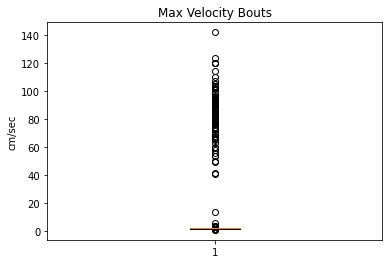

In [91]:
%matplotlib inline
plt.boxplot(max_velocity_bouts(indices))
plt.title('Max Velocity Bouts')
plt.ylabel('cm/sec')
plt.show()

Text(0, 0.5, 'cm/sec')

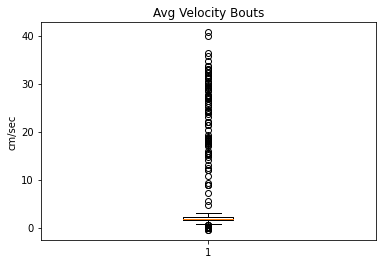

In [65]:
%matplotlib inline
plt.boxplot(avg_velocity_bouts(indices))
plt.title('Avg Velocity Bouts')
plt.ylabel('cm/sec')

#avg_velocity_bouts(indices)

Text(0, 0.5, 'Seconds')

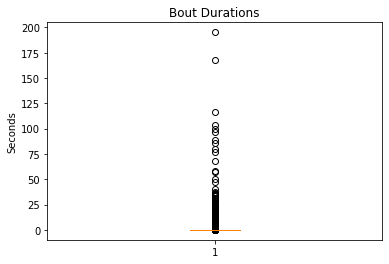

In [66]:
plt.boxplot(duration_of_all_bouts(indices))
plt.title('Bout Durations')
plt.ylabel('Seconds')